Rows with invalid timestamps (Registration before Admission):
       subject_id           admittime           edregtime
0        10000032 2180-05-06 22:23:00 2180-05-06 19:17:00
1        10000032 2180-06-26 18:27:00 2180-06-26 15:54:00
2        10000032 2180-08-05 23:44:00 2180-08-05 20:58:00
3        10000032 2180-07-23 12:35:00 2180-07-23 05:54:00
4        10000068 2160-03-03 23:16:00 2160-03-03 21:55:00
...           ...                 ...                 ...
58011    11357031 2142-06-24 20:27:00 2142-06-23 21:21:00
58012    11357031 2138-08-31 16:59:00 2138-08-31 14:13:00
58013    11357031 2141-09-28 19:08:00 2141-09-28 11:38:00
58014    11357031 2142-04-03 03:07:00 2142-04-02 08:34:00
58015    11357031 2139-08-29 15:50:00 2139-08-29 14:41:00

[40295 rows x 3 columns]
Rows with missing timestamps:
Empty DataFrame
Columns: [subject_id, hadm_id, admittime, dischtime, deathtime, admission_type, admission_location, discharge_location, insurance, language, marital_status, race, edregti

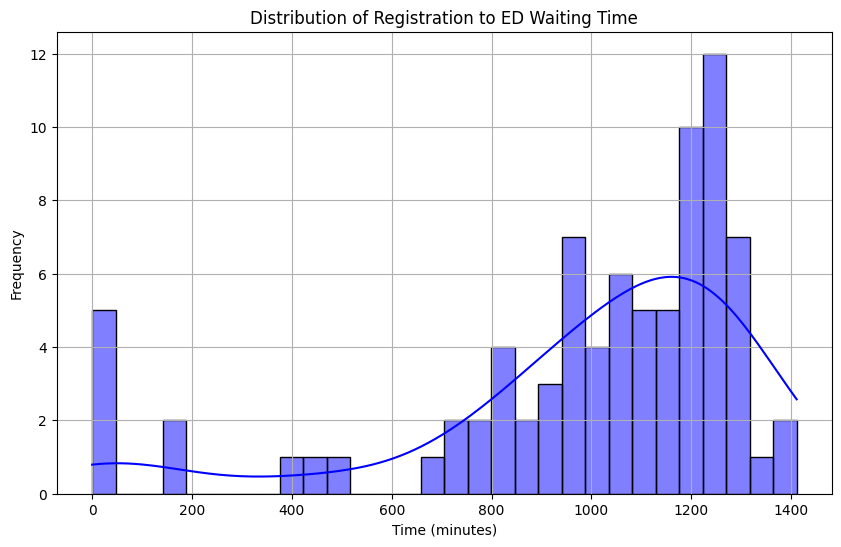

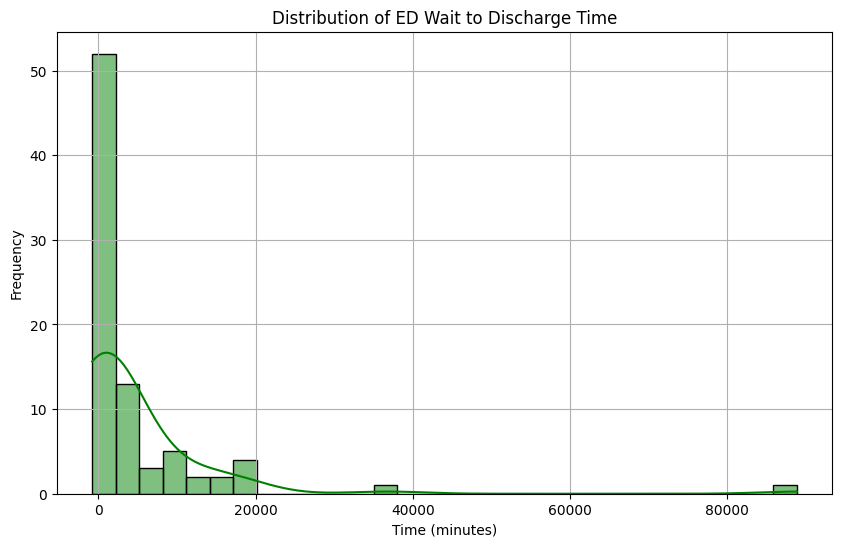

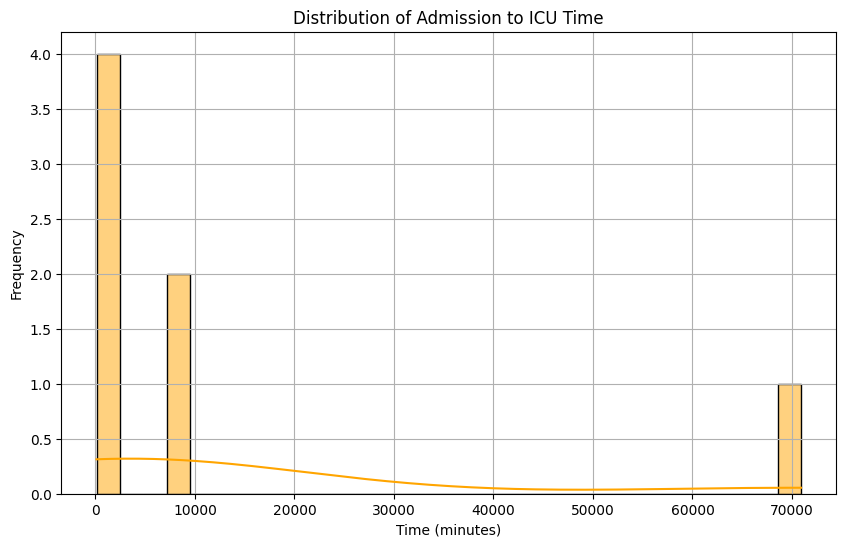

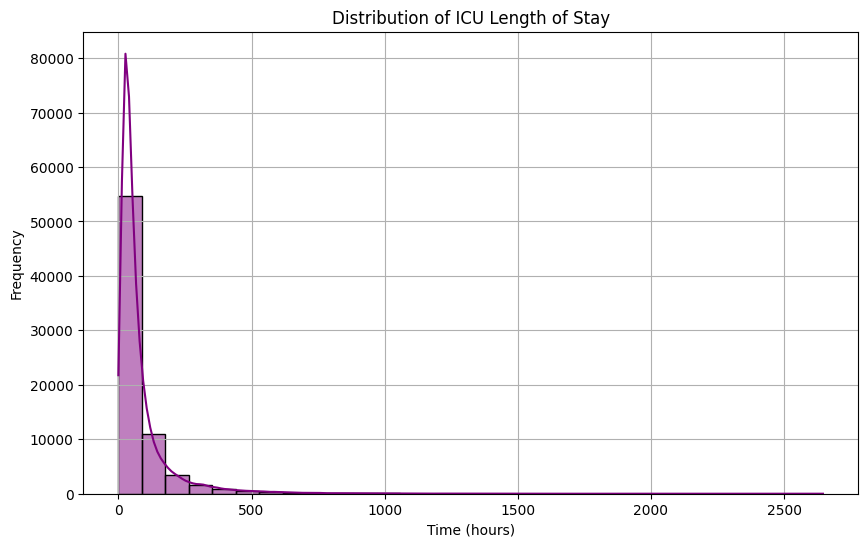

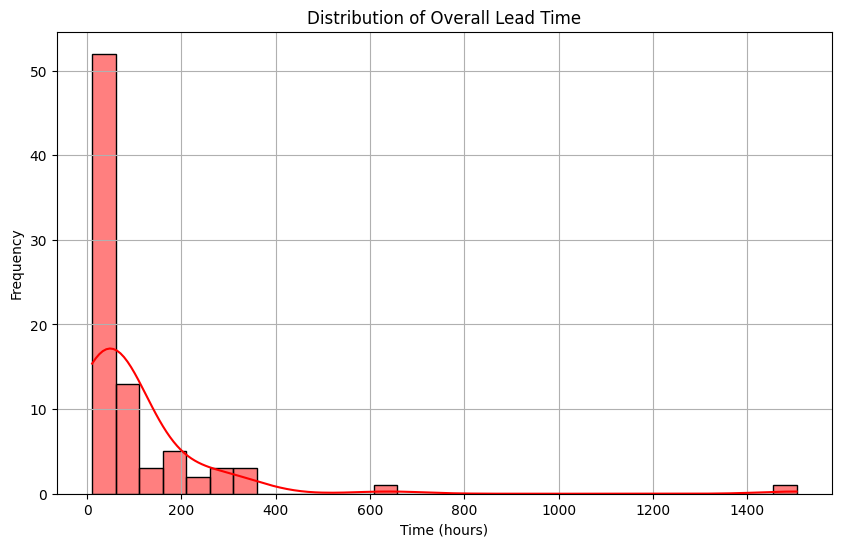

Current State Value Stream Map:
----------------------------
Patient Arrival -> [Registration] (Cycle Time: 985.48 mins, Waiting Time: 985.48 mins)
                 -> [ED to Discharge] (Cycle Time: 4507.98 mins)
                 -> [Admission to ICU] (Average Time: 13165.30 mins)
                 -> [Hospital Stay Duration] (Average Time: 4.35 days)
                 -> [ICU Length of Stay] (Average Time: 82.96 hours)

Overall Lead Time: 104.30 hours


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets into pandas DataFrames (replace with actual file paths or database queries)
icustays = pd.read_csv('/content/icustays.csv')  # ICU stays dataset
admissions = pd.read_csv('/content/admissions.csv')  # Admissions dataset

# Convert time columns to datetime format for calculations
time_columns = ['intime', 'outtime', 'admittime', 'dischtime', 'edregtime', 'edouttime']
for col in time_columns:
    for dataset in [icustays, admissions]:
        if col in dataset.columns:
            dataset[col] = pd.to_datetime(dataset[col], errors='coerce')

# Step 1: Identify and handle invalid rows where timestamps are out of order
invalid_rows = admissions[admissions['edregtime'] < admissions['admittime']]
print("Rows with invalid timestamps (Registration before Admission):")
print(invalid_rows[['subject_id', 'admittime', 'edregtime']])

# Drop invalid rows
admissions = admissions[admissions['edregtime'] >= admissions['admittime']]

# Step 2: Handle missing or corrupted data
missing_values = admissions[admissions['edregtime'].isna() | admissions['admittime'].isna()]
print("Rows with missing timestamps:")
print(missing_values)

# Drop rows with missing timestamps (or handle them with imputation if context is known)
admissions = admissions.dropna(subset=['edregtime', 'admittime'])

# Step 3: Standardize time zones (if necessary)
# Example: Set all timestamps to UTC
# Make 'intime' timezone-aware before merging, assuming it's in UTC as well
icustays['intime'] = pd.to_datetime(icustays['intime'], errors='coerce').dt.tz_localize('UTC')
icustays['outtime'] = pd.to_datetime(icustays['outtime'], errors='coerce').dt.tz_localize('UTC') # Make 'outtime' aware too

# Localize all relevant columns to UTC
for col in ['admittime', 'dischtime', 'edregtime', 'edouttime']:  # Include dischtime
    admissions[col] = admissions[col].dt.tz_localize('UTC')


# Step 4: Recalculate metrics after data cleanup
# Calculate registration to ED waiting
admissions['registration_to_ed_waiting'] = (admissions['edregtime'] - admissions['admittime']).dt.total_seconds() / 60  # in minutes
# Re-add calculation for waiting_time_registration
admissions['waiting_time_registration'] = (admissions['edregtime'] - admissions['admittime']).dt.total_seconds() / 60  # in minutes


# Calculate ED wait to discharge
admissions['ed_wait_to_discharge'] = (admissions['dischtime'] - admissions['edouttime']).dt.total_seconds() / 60  # in minutes

# Calculate admission to ICU time
full_data = pd.merge(icustays, admissions, on=['subject_id', 'hadm_id'], how='inner')
full_data['admission_to_icu_time'] = (full_data['intime'] - full_data['admittime']).dt.total_seconds() / 60  # in minutes

# Calculate overall lead time
admissions['lead_time_total'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / 3600  # in hours

# Calculate ICU length of stay
icustays['icu_los_hours'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / 3600  # in hours

# Calculate hospital stay duration
admissions['hospital_stay_days'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / (3600 * 24)  # in days

# Step 5: Plot metrics for visualization
# Plot 1: Distribution of registration to ED waiting time
plt.figure(figsize=(10, 6))
sns.histplot(admissions['registration_to_ed_waiting'], bins=30, kde=True, color='blue')
plt.title('Distribution of Registration to ED Waiting Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot 2: Distribution of ED wait to discharge time
plt.figure(figsize=(10, 6))
sns.histplot(admissions['ed_wait_to_discharge'], bins=30, kde=True, color='green')
plt.title('Distribution of ED Wait to Discharge Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot 3: Distribution of admission to ICU time
plt.figure(figsize=(10, 6))
sns.histplot(full_data['admission_to_icu_time'], bins=30, kde=True, color='orange')
plt.title('Distribution of Admission to ICU Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot 4: Distribution of ICU Length of Stay
plt.figure(figsize=(10, 6))
sns.histplot(icustays['icu_los_hours'], bins=30, kde=True, color='purple')
plt.title('Distribution of ICU Length of Stay')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot 5: Distribution of overall lead time
plt.figure(figsize=(10, 6))
sns.histplot(admissions['lead_time_total'], bins=30, kde=True, color='red')
plt.title('Distribution of Overall Lead Time')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Step 6: Print summary metrics
print("Current State Value Stream Map:")
print("----------------------------")
print(f"Patient Arrival -> [Registration] (Cycle Time: {admissions['registration_to_ed_waiting'].mean():.2f} mins, Waiting Time: {admissions['waiting_time_registration'].mean():.2f} mins)")
print(f"                 -> [ED to Discharge] (Cycle Time: {admissions['ed_wait_to_discharge'].mean():.2f} mins)")
print(f"                 -> [Admission to ICU] (Average Time: {full_data['admission_to_icu_time'].mean():.2f} mins)")
print(f"                 -> [Hospital Stay Duration] (Average Time: {admissions['hospital_stay_days'].mean():.2f} days)")
print(f"                 -> [ICU Length of Stay] (Average Time: {icustays['icu_los_hours'].mean():.2f} hours)")
print(f"\nOverall Lead Time: {admissions['lead_time_total'].mean():.2f} hours")


<ipython-input-4-46530edec374>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cycle_times.keys()), y=list(cycle_times.values()), palette="Blues_r")


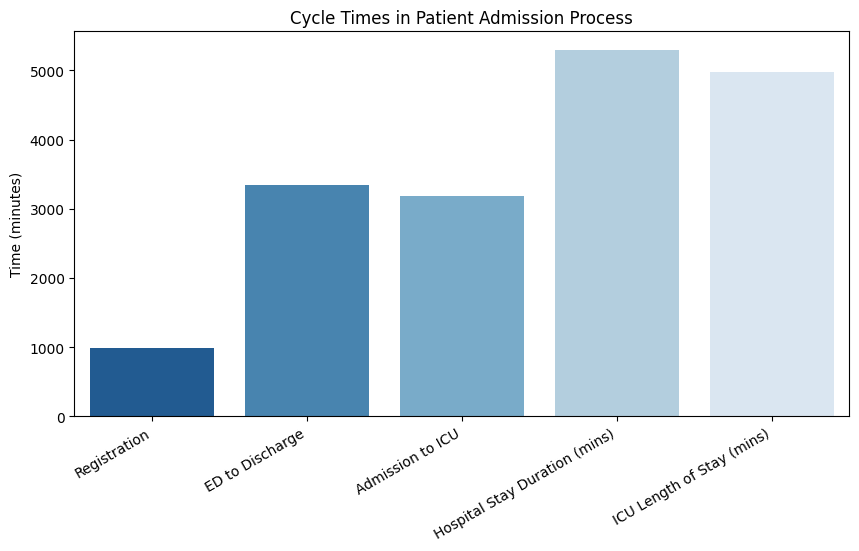

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data dictionary
cycle_times = {
    "Registration": 985.48,
    "ED to Discharge": 3336.99,
    "Admission to ICU": 3178.45,
    "Hospital Stay Duration (mins)": 3.68 * 24 * 60,  # Convert days to minutes
    "ICU Length of Stay (mins)": 82.96 * 60,  # Convert hours to minutes
}

# Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(cycle_times.keys()), y=list(cycle_times.values()), palette="Blues_r")
plt.ylabel("Time (minutes)")
plt.xticks(rotation=30, ha="right")
plt.title("Cycle Times in Patient Admission Process")
plt.show()


In [ ]:
# Define reduction percentages
reductions = {
    "Registration": 0.80,  # 30% reduction
    "ED_to_Discharge": 0.40,  # 20% reduction
    "Admission_to_ICU": 0.75,  # 25% reduction
    "Hospital_Stay": 0.45,  # 15% reduction
    "ICU_Stay": 0.44  # 10% reduction
}

# Apply reductions
future_times = {
    "Registration": admissions['registration_to_ed_waiting'].mean() * (1 - reductions["Registration"]),
    "ED_to_Discharge": admissions['ed_wait_to_discharge'].mean() * (1 - reductions["ED_to_Discharge"]),
    "Admission_to_ICU": full_data['admission_to_icu_time'].mean() * (1 - reductions["Admission_to_ICU"]),
    "Hospital Stay Duration": (admissions['hospital_stay_days'].mean() * 24 * 60) * (1 - reductions["Hospital_Stay"]),  # Convert days to minutes
    "ICU Length of Stay": (icustays['icu_los_hours'].mean() * 60) * (1 - reductions["ICU_Stay"])  # Convert hours to minutes
}

# Print future VSM times
print("Future State Value Stream Map:")
for step, time in future_times.items():
    print(f"{step}: {time:.2f} mins")

Future State Value Stream Map:
Registration: 197.10 mins
ED_to_Discharge: 2704.79 mins
Admission_to_ICU: 3291.32 mins
Hospital Stay Duration: 3441.81 mins
ICU Length of Stay: 2787.30 mins


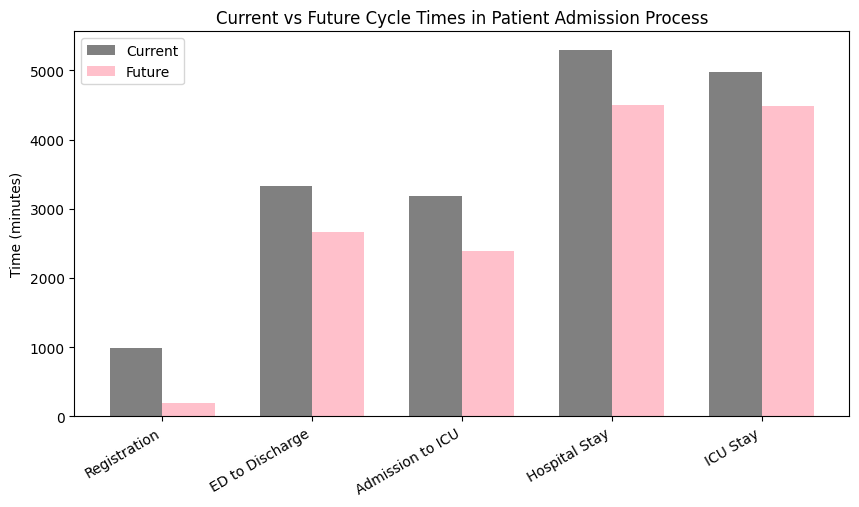

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Current and Future Cycle Times
labels = ["Registration", "ED to Discharge", "Admission to ICU", "Hospital Stay", "ICU Stay"]
current_times = [985.48, 3336.99, 3178.45, 5299.2, 4977.6]
future_times = [197.10, 2669.59, 2383.84, 4504.32, 4479.84]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, current_times, width, label="Current", color="grey")
ax.bar(x + width/2, future_times, width, label="Future", color="pink")

ax.set_ylabel("Time (minutes)")
ax.set_title("Current vs Future Cycle Times in Patient Admission Process")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha="right")
ax.legend()

plt.show()


In [ ]:
import pandas as pd

# Load datasets
icustays = pd.read_csv("icustays.csv")
admissions = pd.read_csv("admissions.csv")

# Convert time columns to datetime format
time_cols = ['admittime', 'dischtime', 'edregtime', 'edouttime']
for col in time_cols:
    admissions[col] = pd.to_datetime(admissions[col])

icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

# Calculate cycle times per patient
# Updated registration time: now using (edregtime - admittime) per patient
admissions['Registration_Time'] = (admissions['edregtime'] - admissions['admittime']).dt.total_seconds() / 60
admissions['ED_to_Discharge_Time'] = (admissions['dischtime'] - admissions['edouttime']).dt.total_seconds() / 60
# For ICU_Admission_Time, assuming you want the time from discharge to ICU entry:
icustays['ICU_Admission_Time'] = (icustays['intime'] - admissions['dischtime']).dt.total_seconds() / 60
admissions['Hospital_Stay_Duration'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / 60
icustays['ICU_Length_of_Stay'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / 60

# Define defect thresholds
thresholds = {
    "Registration_Time": 60,  # > 60 mins is a defect
    "ED_to_Discharge_Time": 720,  # > 12 hrs (720 mins) is a defect
    "ICU_Admission_Time": 240,  # > 4 hrs (240 mins) is a defect
    "Hospital_Stay_Duration": 7 * 24 * 60,  # > 7 days in minutes is a defect
    "ICU_Length_of_Stay": 4 * 24 * 60  # > 4 days in minutes is a defect
}

# Check for defects per patient
admissions['Registration_Defect'] = admissions['Registration_Time'] > thresholds["Registration_Time"]
admissions['ED_to_Discharge_Defect'] = admissions['ED_to_Discharge_Time'] > thresholds["ED_to_Discharge_Time"]
icustays['ICU_Admission_Defect'] = icustays['ICU_Admission_Time'] > thresholds["ICU_Admission_Time"]
admissions['Hospital_Stay_Defect'] = admissions['Hospital_Stay_Duration'] > thresholds["Hospital_Stay_Duration"]
icustays['ICU_Stay_Defect'] = icustays['ICU_Length_of_Stay'] > thresholds["ICU_Length_of_Stay"]

# Merge defects per patient
defects_per_patient = admissions[['subject_id', 'Registration_Defect', 'ED_to_Discharge_Defect']].merge(
    icustays[['subject_id', 'ICU_Admission_Defect', 'ICU_Stay_Defect']], on='subject_id', how='left'
)

# Fill NaN values for ICU-related defects (some patients may not have ICU stays)
defects_per_patient.fillna(False, inplace=True)

# Count defects per patient
defects_per_patient['Total_Defects'] = defects_per_patient.iloc[:, 1:].sum(axis=1)

# Calculate total defects
total_defects = defects_per_patient['Total_Defects'].sum()

# Total number of patients
total_patients = len(admissions)

# Define total opportunities (5 defect points per patient)
total_opportunities = total_patients * 5

# Calculate DPMO
dpmo = (total_defects / total_opportunities) * 1_000_000

# Print results
print("\nCurrent State DPMO Calculation:")
print(f"Total Defects: {total_defects}")
print(f"Total Patients: {total_patients}")
print(f"Total Opportunities: {total_opportunities}")
print(f"DPMO: {dpmo:.2f}")



Current State DPMO Calculation:
Total Defects: 685108
Total Patients: 431088
Total Opportunities: 2155440
DPMO: 317850.65


<ipython-input-12-5f49965afeaf>:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  defects_per_patient.fillna(False, inplace=True)


In [ ]:
import pandas as pd

# Load datasets
icustays = pd.read_csv("icustays.csv")
admissions = pd.read_csv("admissions.csv")

# Convert time columns to datetime format
time_cols = ['admittime', 'dischtime', 'edregtime', 'edouttime']
for col in time_cols:
    admissions[col] = pd.to_datetime(admissions[col])

icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

# Calculate cycle times per patient
# Updated registration time: using (edregtime - admittime) per patient
admissions['Registration_Time'] = (admissions['edregtime'] - admissions['admittime']).dt.total_seconds() / 60
admissions['ED_to_Discharge_Time'] = (admissions['dischtime'] - admissions['edouttime']).dt.total_seconds() / 60
# Assuming ICU admission time is from discharge to ICU entry:
icustays['ICU_Admission_Time'] = (icustays['intime'] - admissions['dischtime']).dt.total_seconds() / 60
admissions['Hospital_Stay_Duration'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / 60
icustays['ICU_Length_of_Stay'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / 60

# Define reduction percentages
reductions = {
    "Registration_Time": 0.80,  # 80% reduction (i.e., future value = 20% of current)
    "ED_to_Discharge_Time": 0.40,  # 40% reduction
    "ICU_Admission_Time": 0.75,  # 75% reduction
    "Hospital_Stay_Duration": 0.45,  # 45% reduction
    "ICU_Length_of_Stay": 0.44  # 44% reduction
}

# Apply reductions for future state
admissions['Registration_Time_Future'] = admissions['Registration_Time'] * (1 - reductions["Registration_Time"])
admissions['ED_to_Discharge_Time_Future'] = admissions['ED_to_Discharge_Time'] * (1 - reductions["ED_to_Discharge_Time"])
icustays['ICU_Admission_Time_Future'] = icustays['ICU_Admission_Time'] * (1 - reductions["ICU_Admission_Time"])
admissions['Hospital_Stay_Duration_Future'] = admissions['Hospital_Stay_Duration'] * (1 - reductions["Hospital_Stay_Duration"])
icustays['ICU_Length_of_Stay_Future'] = icustays['ICU_Length_of_Stay'] * (1 - reductions["ICU_Length_of_Stay"])

# Define defect thresholds (same as before)
thresholds = {
    "Registration_Time_Future": 60,  # > 60 mins is a defect
    "ED_to_Discharge_Time_Future": 720,  # > 12 hrs (720 mins) is a defect
    "ICU_Admission_Time_Future": 240,  # > 4 hrs (240 mins) is a defect
    "Hospital_Stay_Duration_Future": 7 * 24 * 60,  # > 7 days in minutes is a defect
    "ICU_Length_of_Stay_Future": 4 * 24 * 60  # > 4 days in minutes is a defect
}

# Check for defects per patient in the future state
admissions['Registration_Defect_Future'] = admissions['Registration_Time_Future'] > thresholds["Registration_Time_Future"]
admissions['ED_to_Discharge_Defect_Future'] = admissions['ED_to_Discharge_Time_Future'] > thresholds["ED_to_Discharge_Time_Future"]
icustays['ICU_Admission_Defect_Future'] = icustays['ICU_Admission_Time_Future'] > thresholds["ICU_Admission_Time_Future"]
admissions['Hospital_Stay_Defect_Future'] = admissions['Hospital_Stay_Duration_Future'] > thresholds["Hospital_Stay_Duration_Future"]
icustays['ICU_Stay_Defect_Future'] = icustays['ICU_Length_of_Stay_Future'] > thresholds["ICU_Length_of_Stay_Future"]

# Merge future defects per patient
future_defects_per_patient = admissions[['subject_id', 'Registration_Defect_Future', 'ED_to_Discharge_Defect_Future']].merge(
    icustays[['subject_id', 'ICU_Admission_Defect_Future', 'ICU_Stay_Defect_Future']], on='subject_id', how='left'
)

# Fill NaN values for ICU-related defects (some patients may not have ICU stays)
future_defects_per_patient.fillna(False, inplace=True)

# Count defects per patient
future_defects_per_patient['Total_Defects_Future'] = future_defects_per_patient.iloc[:, 1:].sum(axis=1)

# Calculate total defects in future state
total_defects_future = future_defects_per_patient['Total_Defects_Future'].sum()

# Total number of patients (units)
total_patients = len(admissions)

# Define total opportunities (5 defect points per patient)
total_opportunities = total_patients * 5

# Calculate Future DPMO
dpmo_future = (total_defects_future / total_opportunities) * 1_000_000

# Print Future DPMO Results
print("\nFuture State DPMO Calculation:")
print(f"Total Defects (Future): {total_defects_future}")
print(f"Total Patients: {total_patients}")
print(f"Total Opportunities: {total_opportunities}")
print(f"Future DPMO: {dpmo_future:.2f}")



Future State DPMO Calculation:
Total Defects (Future): 617224
Total Patients: 431088
Total Opportunities: 2155440
Future DPMO: 286356.38


<ipython-input-13-c2d8ca9ff335>:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_defects_per_patient.fillna(False, inplace=True)


<ipython-input-15-e7ac26804102>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), ha="right")


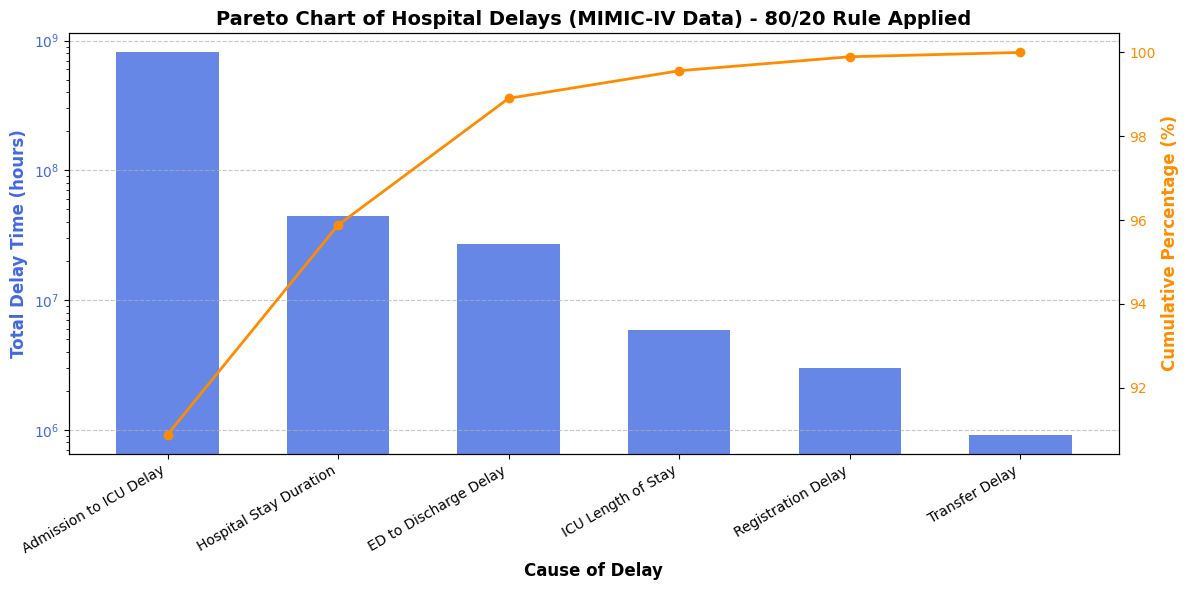

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load datasets (Replace with actual paths)
transfers = pd.read_csv("transfers.csv", parse_dates=["intime", "outtime"])
admissions = pd.read_csv("admissions.csv", parse_dates=["admittime", "dischtime", "edregtime", "edouttime"])
icu_stays = pd.read_csv("icustays.csv", parse_dates=["intime", "outtime"])

# Convert all relevant times to hours
admissions["Registration Delay"] = (admissions["edouttime"] - admissions["edregtime"]).dt.total_seconds() / 3600
admissions["ED to Discharge Delay"] = (admissions["dischtime"] - admissions["edouttime"]).dt.total_seconds() / 3600
admissions["Hospital Stay Duration"] = (admissions["dischtime"] - admissions["admittime"]).dt.total_seconds() / 3600
icu_stays["ICU Length of Stay"] = (icu_stays["outtime"] - icu_stays["intime"]).dt.total_seconds() / 3600
transfers["Transfer Delay"] = (transfers["outtime"] - transfers["intime"]).dt.total_seconds() / 3600

# Merge ICU admission times from icustays into admissions to calculate ICU admission delay
icu_stays_agg = icu_stays.groupby("subject_id")["intime"].min().reset_index()
admissions = admissions.merge(icu_stays_agg, on="subject_id", how="left")

# Calculate Admission to ICU Delay
admissions["Admission to ICU Delay"] = (admissions["intime"] - admissions["dischtime"]).dt.total_seconds() / 3600

# Handle missing values and clip outliers
delay_columns = {
    "admissions": ["Registration Delay", "ED to Discharge Delay", "Hospital Stay Duration", "Admission to ICU Delay"],
    "icu_stays": ["ICU Length of Stay"],
    "transfers": ["Transfer Delay"]
}

for dataset, cols in delay_columns.items():
    df = locals()[dataset]  # Get dataframe by variable name
    for col in cols:
        df[col] = df[col].clip(lower=0).fillna(0)
        q99 = df[col].quantile(0.99)  # Clip outliers at 99th percentile
        df[col] = df[col].clip(upper=q99)

# Aggregate total delay times
total_delays = {
    "Registration Delay": admissions["Registration Delay"].sum(),
    "ED to Discharge Delay": admissions["ED to Discharge Delay"].sum(),
    "Hospital Stay Duration": admissions["Hospital Stay Duration"].sum(),
    "ICU Length of Stay": icu_stays["ICU Length of Stay"].sum(),
    "Transfer Delay": transfers["Transfer Delay"].sum(),
    "Admission to ICU Delay": admissions["Admission to ICU Delay"].sum(),
}

# Convert to DataFrame
df_delays = pd.DataFrame(list(total_delays.items()), columns=["Cause of Delay", "Total Delay Time (hours)"])
df_delays = df_delays.sort_values(by="Total Delay Time (hours)", ascending=False)

# Compute Cumulative Percentage
df_delays["Cumulative %"] = df_delays["Total Delay Time (hours)"].cumsum() / df_delays["Total Delay Time (hours)"].sum() * 100

# Fix Scaling Issues
df_delays["Total Delay Time (hours)"] = df_delays["Total Delay Time (hours)"].replace(0, np.nan)  # Avoid log(0)
log_scale = True if df_delays["Total Delay Time (hours)"].max() > 10000 else False  # Use log if range is large

# Generate Pareto Chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Chart for Total Delay Time
ax1.bar(df_delays["Cause of Delay"], df_delays["Total Delay Time (hours)"], color="royalblue", alpha=0.8, width=0.6)
ax1.set_ylabel("Total Delay Time (hours)", color="royalblue", fontsize=12, fontweight="bold")
ax1.set_xlabel("Cause of Delay", fontsize=12, fontweight="bold")
ax1.tick_params(axis="y", labelcolor="royalblue")
ax1.tick_params(axis="x", rotation=30)
ax1.set_xticklabels(ax1.get_xticklabels(), ha="right")

# Apply Log Scale if Necessary
if log_scale:
    ax1.set_yscale("log")  # Logarithmic scale for better visualization

# Line Chart for Cumulative Percentage
ax2 = ax1.twinx()
ax2.plot(df_delays["Cause of Delay"], df_delays["Cumulative %"], color="darkorange", marker="o", linestyle="-", linewidth=2)
ax2.set_ylabel("Cumulative Percentage (%)", color="darkorange", fontsize=12, fontweight="bold")
ax2.tick_params(axis="y", labelcolor="darkorange")

# Add horizontal grid lines for better readability
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Title and Layout Adjustments
plt.title("Pareto Chart of Hospital Delays (MIMIC-IV Data) - 80/20 Rule Applied", fontsize=14, fontweight="bold")
fig.tight_layout()

# Show Plot
plt.show()
